In [2]:
#  no aug
#  обрезка первой секунды
# только мфсс с энергией
# окно хемминга

In [1]:
from tensorflow.python.client import device_lib
device_lib.list_local_devices()

/home/lovely/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 12394246513163800247, name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 1499201536
 locality {
   bus_id: 1
 }
 incarnation: 5361138285457532280
 physical_device_desc: "device: 0, name: GeForce 940MX, pci bus id: 0000:01:00.0, compute capability: 5.0"]

In [2]:
import os
import librosa
import librosa.display
import numpy as np
import keras
from keras import models
from keras import layers
from keras import optimizers
from keras import backend as K
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from python_speech_features import base as speech
%matplotlib inline

Using TensorFlow backend.


In [3]:
winlen = 0.025 # the length of the analysis window in seconds (25 milliseconds)
winstep = 0.01    # the step between successive windows in seconds (10 milliseconds)
preemph = 0.97   # coefficient

nfilt = 40 # ?? the number of filters in the filterbank, default 26.
nfft = 512 * 3 # ?? the FFT size. Default is 512.

numcep = 13 # ?? num of cepstral coefs
ceplifter = 0 # apply a lifter to final cepstral coefficients. 0 is no lifter 22

winfunc = np.hamming # lambda x: np.ones((x,)) # window function

In [4]:
# откинем те, которые нейтральные 

# ? возможно понадобится:
# попытаемся обрезать первые секунды молчания во всех записях
# потом надо привести их к одной длине

In [5]:
classes = np.array(['angry', 'calm', 'disgust', 'fearful', 'happy', 'sad', 'surprised']) # no neutral

In [6]:
all_mel_cepstral_coefficients = []
all_class_labels = []

path = 'RAVDESS/0_all_speech/'

In [7]:
# shapes = []

min_sig_len = 140941
max_sig_len = 253053

In [8]:
for file in os.listdir(path):
    class_label = file.split('-')[0]
    
    if not 'neutral' in class_label:
        signal, samplerate = librosa.core.load(path+file, sr=48000)
        
        class_label = np.where(classes == class_label)[0][0]
        
        signal = np.pad(signal,(0,max_sig_len-len(signal)), mode='constant')

        mfccs = speech.mfcc(\
                        signal, \
                        nfft=nfft,\
                        appendEnergy=True,\
                        samplerate=samplerate,\
                        numcep=numcep,\
                        nfilt=nfilt,\
                        winfunc=winfunc
              )
    
        all_mel_cepstral_coefficients.append(mfccs)
        all_class_labels.append(class_label)

/home/lovely/anaconda3/lib/python3.6/site-packages/mkl_fft/_numpy_fft.py:331: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  output = mkl_fft.rfft_numpy(a, n=n, axis=axis)


In [ ]:
speech

In [9]:
all_mel_cepstral_coefficients = np.array(all_mel_cepstral_coefficients) 
all_class_labels = np.array(all_class_labels)

In [10]:
all_mel_cepstral_coefficients.shape, all_class_labels.shape

((1344, 526, 13), (1344,))

In [11]:
np.where(all_class_labels == 0)

(array([  29,   36,   40,   52,   59,   65,   66,   89,   92,  116,  119,
         120,  123,  131,  134,  135,  137,  138,  142,  145,  154,  158,
         177,  181,  185,  198,  199,  202,  225,  232,  249,  252,  253,
         257,  263,  265,  284,  285,  287,  289,  291,  296,  312,  317,
         320,  328,  342,  343,  345,  347,  352,  359,  363,  369,  371,
         381,  384,  408,  409,  423,  425,  437,  443,  449,  455,  457,
         463,  471,  472,  488,  491,  498,  499,  503,  514,  517,  518,
         521,  522,  524,  533,  540,  558,  562,  571,  572,  577,  585,
         601,  603,  619,  623,  625,  634,  650,  654,  658,  660,  671,
         681,  689,  696,  713,  727,  735,  738,  754,  772,  776,  793,
         802,  806,  814,  827,  829,  832,  844,  846,  849,  857,  858,
         872,  874,  876,  877,  882,  885,  891,  898,  899,  900,  902,
         913,  918,  924,  932,  953,  957,  962,  964,  983,  992,  995,
        1008, 1011, 1013, 1022, 1043, 

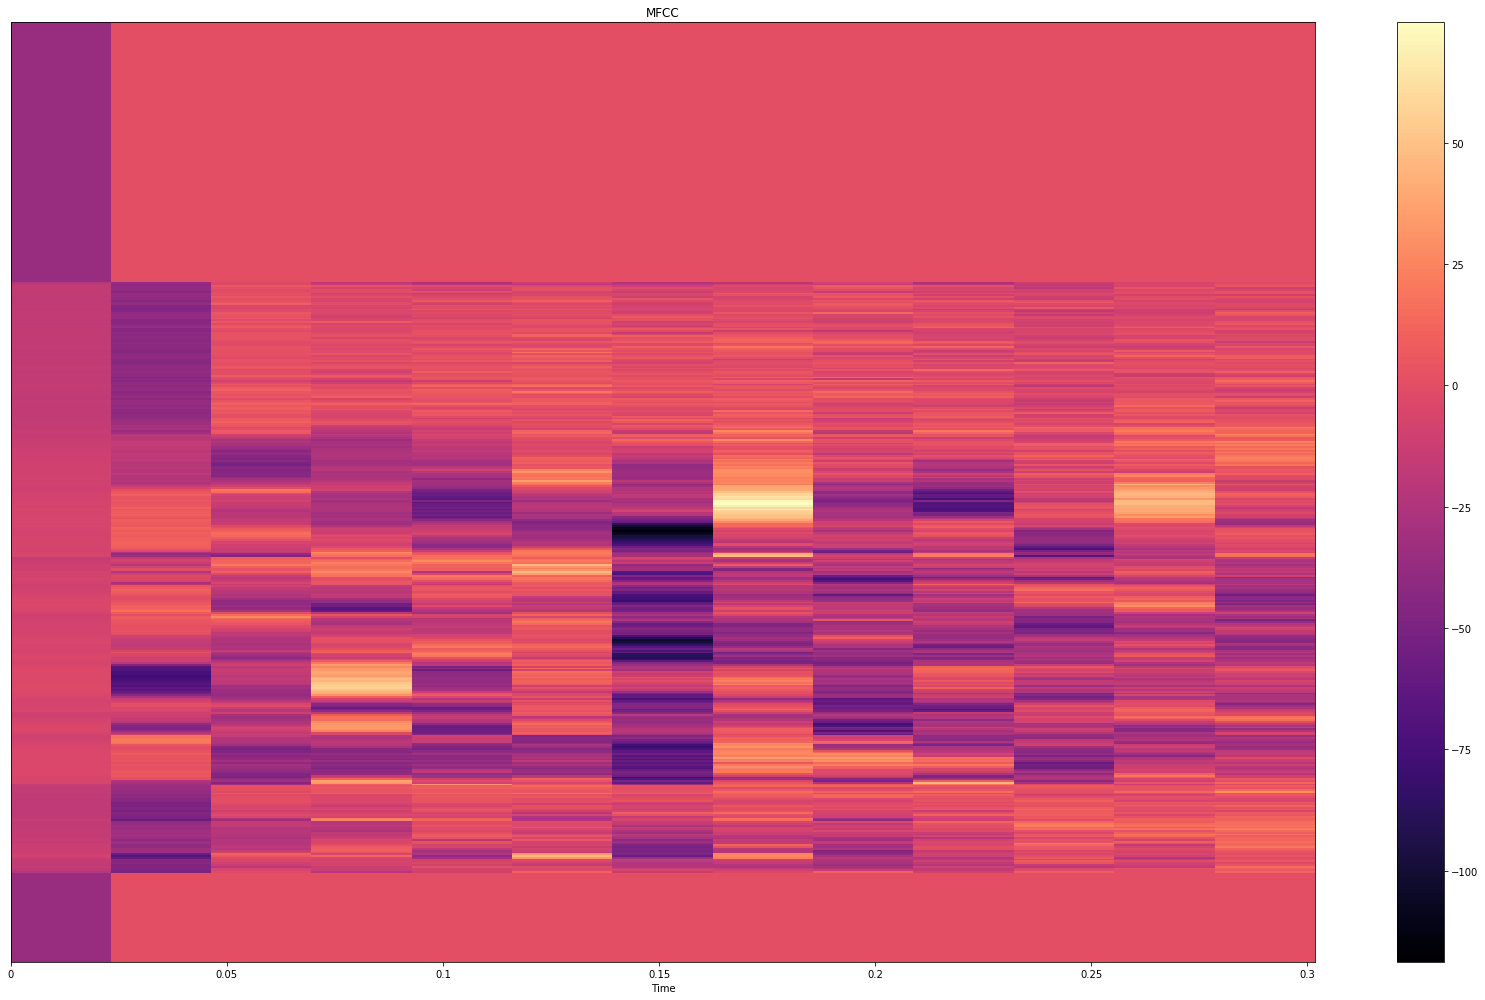

In [12]:
plt.figure(figsize=(23, 14))
librosa.display.specshow(all_mel_cepstral_coefficients[882], x_axis='time',cmap='magma')
plt.colorbar()
plt.title('MFCC')
plt.tight_layout()

In [13]:
num_of_classes = len(set(all_class_labels)) # 8
all_class_labels

array([1, 1, 3, ..., 3, 6, 5])

In [14]:
num_of_classes

7

In [15]:
min_ = np.amax(all_mel_cepstral_coefficients)
max_ = np.amin(all_mel_cepstral_coefficients)

In [16]:
rescaled = (all_mel_cepstral_coefficients - min_) / (max_ - min_)

In [17]:
X = rescaled.reshape(rescaled.shape[0], rescaled.shape[1], 13, 1)
Y = keras.utils.to_categorical(all_class_labels, num_of_classes)

In [20]:
np.random.seed(7)

In [21]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y)

In [39]:
layers.TimeDistributed??

In [ ]:
model = Sequential()
        model.add(TimeDistributed(Conv2D(64, (3, 3)),
                                  input_shape=(10, 299, 299, 3))

In [ ]:
lay

In [46]:
X_train.shape

(1008, 526, 13, 1)

In [42]:
model = models.Sequential()

model.add(layers.TimeDistributed(layers.Conv2D(32,\
                                               activation='relu', \
                                               kernel_size=(3, 3),\
                                               padding='valid',\
                                               ),\
                                                 input_shape=X_train.shape
                                              ))

In [43]:
model.add(layers.TimeDistributed(layers.MaxPool2D(pool_size=(2,2))))
model.add(layers.TimeDistributed(layers.Flatten()))

model.add(layers.LSTM(10))
model.add(layers.Dense(num_of_classes))
model.add(layers.Lambda(lambda x: K.tf.nn.softmax(x)))

In [44]:
# model.compile(loss='categorical_crossentropy', optimizer='adadelta', metrics=['accuracy'])

# sgd = optimizers.SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy',])

In [45]:
history = model.fit(X_train, Y_train, validation_split=0.25, batch_size=35, epochs=50, verbose=True)

ValueError: Error when checking input: expected time_distributed_9_input to have 5 dimensions, but got array with shape (1008, 526, 13, 1)

In [25]:
model.evaluate(X_test, Y_test)

336/336 [==============================] - 0s 607us/step


[1.4044365882873535, 0.47619047619047616]

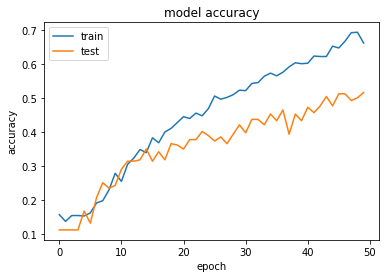

In [26]:
plt.plot(history.history['acc'])
plt.title('model accuracy')
plt.plot(history.history['val_acc'])
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

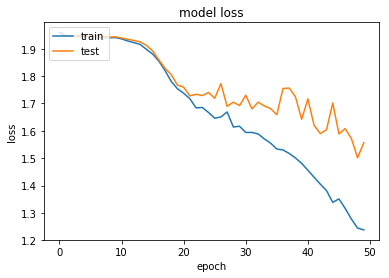

In [78]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:
#  test with another type of preprocessing (instead of min-max)

In [81]:
all_mel_cepstral_coefficients.shape

(1344, 526, 13)

In [102]:
# 0.5[tanh(0.01(s-μ)/σ + 1]

tanh_scaled_mfcc = []

for el in all_mel_cepstral_coefficients:
    s = 0.5*(np.tanh(0.01*(el - np.mean(el))/np.std(el) + 1 ))
    tanh_scaled_mfcc.append(s)

In [103]:
tanh_scaled_mfcc = np.array(tanh_scaled_mfcc)

In [107]:
tanh_scaled_mfcc.shape

(1344, 526, 13)

In [120]:
X = tanh_scaled_mfcc.reshape(tanh_scaled_mfcc.shape[0], tanh_scaled_mfcc.shape[1], 13, 1)
Y = keras.utils.to_categorical(all_class_labels, num_of_classes)
X_train, X_test, Y_train, Y_test = train_test_split(X, Y)


# X = all_mel_cepstral_coefficients.reshape(all_mel_cepstral_coefficients.shape[0], all_mel_cepstral_coefficients.shape[1], 13, 1)
# Y = keras.utils.to_categorical(all_class_labels, num_of_classes)
# X_train, X_test, Y_train, Y_test = train_test_split(X, Y)

In [132]:
model = models.Sequential()

model.add(layers.Conv2D(32,  activation='relu', kernel_size=(3, 3),padding='valid', input_shape=X.shape[1:]))
model.add(layers.MaxPool2D(pool_size=(2,2)))

model.add(layers.Dropout(0.2))

model.add(layers.Conv2D(32,  activation='relu', kernel_size=(2, 2),padding='valid'))
model.add(layers.MaxPool2D(pool_size=(2,2)))
model.add(layers.Dropout(0.2))

model.add(layers.Conv2D(64,  activation='relu', kernel_size=(1, 1),padding='valid'))
model.add(layers.MaxPool2D(pool_size=(2,2)))
model.add(layers.Dropout(0.2))

model.add(layers.Flatten())
model.add(layers.Dense(num_of_classes))
model.add(layers.Lambda(lambda x: K.tf.nn.softmax(x)))

In [133]:
sgd = optimizers.SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)
model.compile(loss='categorical_crossentropy',
              optimizer='adadelta',
              metrics=['accuracy',])

In [134]:
history = model.fit(X_train, Y_train, validation_split=0.25, batch_size=35, epochs=50, verbose=True)

Train on 756 samples, validate on 252 samples
Epoch 1/50
756/756 [==============================] - 2s 3ms/step - loss: 1.9638 - acc: 0.1534 - val_loss: 1.9456 - val_acc: 0.1349
Epoch 2/50
756/756 [==============================] - 1s 2ms/step - loss: 1.9509 - acc: 0.1243 - val_loss: 1.9464 - val_acc: 0.1310
Epoch 3/50
756/756 [==============================] - 1s 2ms/step - loss: 1.9473 - acc: 0.1508 - val_loss: 1.9468 - val_acc: 0.1310
Epoch 4/50
756/756 [==============================] - 1s 2ms/step - loss: 1.9477 - acc: 0.1349 - val_loss: 1.9466 - val_acc: 0.1310
Epoch 5/50
756/756 [==============================] - 1s 2ms/step - loss: 1.9462 - acc: 0.1349 - val_loss: 1.9472 - val_acc: 0.1310
Epoch 6/50
756/756 [==============================] - 1s 2ms/step - loss: 1.9465 - acc: 0.1402 - val_loss: 1.9475 - val_acc: 0.1310
Epoch 7/50
756/756 [==============================] - 1s 2ms/step - loss: 1.9467 - acc: 0.1310 - val_loss: 1.9473 - val_acc: 0.1310
Epoch 8/50
756/756 [==========

In [135]:
model.evaluate(X_test, Y_test)

336/336 [==============================] - 0s 514us/step


[1.947690214429583, 0.13392857142857142]

In [ ]:
# data augmentation test

In [79]:
# from keras.preprocessing.image import ImageDataGenerator

In [ ]:
# datagen = ImageDataGenerator ()

In [ ]:
model = models.Sequential()

model.add(layers.Conv2D(32,  activation='relu', kernel_size=(3, 3),padding='valid', input_shape=X.shape[1:]))
model.add(layers.MaxPool2D(pool_size=(2,2)))

model.add(layers.Dropout(0.2))

model.add(layers.Conv2D(32,  activation='relu', kernel_size=(2, 2),padding='valid'))
model.add(layers.MaxPool2D(pool_size=(2,2)))
model.add(layers.Dropout(0.2))

model.add(layers.Conv2D(64,  activation='relu', kernel_size=(1, 1),padding='valid'))
model.add(layers.MaxPool2D(pool_size=(2,2)))
model.add(layers.Dropout(0.2))

model.add(layers.Flatten())
model.add(layers.Dense(num_of_classes))
model.add(layers.Lambda(lambda x: K.tf.nn.softmax(x)))